In [1]:
import numpy as np
import quaternion
import matplotlib.pyplot as plt
import pandapybullet as ppb
import pybullet
import time
from scipy.optimize import minimize, Bounds, NonlinearConstraint, BFGS

%load_ext autoreload
%autoreload 2

/home/julius/.local/lib/python3.8/site-packages/quaternion/numba_wrapper.py:21: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


## Panda Simulation

In [2]:
dt_con = 0.0005 #dt
ndof = 7

world_sim = ppb.WorldSim(gravity=[0,0,-10], mode='DIRECT',realtime=False)
world_sim.set_time_step(dt_con)
world_sim.setup_scene()
robot = world_sim.load_panda(pos=[0,0,0], orn=[0,0,0])

/home/julius/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [3]:
def quat_log_error(q_1, q_2):
    dq = q_1 * q_2.conjugate()
    return quaternion.as_rotation_vector(dq)

def quat_rect(q, q_d):
    q_vec = quaternion.as_float_array(q)
    q_d_vec = quaternion.as_float_array(q_d)
    e_euclidean = q_vec-q_d_vec
    if e_euclidean.dot(e_euclidean) > 2:
        return -q
    return q

def robot_quaternion(robot):
    robot.rotation = 'mat'
    R_ = robot.orn
    quat_ = quaternion.from_rotation_matrix(R_)
    return quat_

In [4]:
q_0 = np.array([0.63, -0.23 , 0., -1.7, 0, 1.51, 0.72]) # Initial joint configuration of the robot
dq_0 = np.array([0., 0. , 0., 0., 0., 0., 0.]) # Initial joint velocity of the robot

qMax = np.array([2.8973 , 1.7628 , 2.8973 , -0.0698 , 2.8973 , 3.7525 , 2.8973])
qMin = np.array([-2.8973 , -1.7628 , -2.8973 , -3.0718 , -2.8973 , -0.0175 , -2.8973])

dq_lim = 0.8
ddq_lim = 2

In [5]:
x_1 = np.array([0.1, -0.5, 0.5])
quat_1 = np.quaternion(0., 1., 0., 0.)

x_2 = np.array([0.6, 0.0, 0.05])
quat_2 = np.quaternion(0., 1., 0., 0.)
dq_2 = np.zeros(7)

## Initialization IK

In [6]:
def getIK(q0, x_d, quat_d, alpha=0.1, numIter=100):
    q = q0 + 0. # instead of deep copy
    for i in range(numIter):
        robot.set_q_(q)
        x = robot.x
        quat = quat_rect(robot_quaternion(robot), quat_d)
        J = robot.J
        dx = - (x - x_d)
        w = 2 * quat_log_error(quat_d,quat)
        q += (alpha * np.linalg.pinv(J) @ np.concatenate((dx,w))).reshape(np.size(q0))
    return q

In [7]:
q_1_init = getIK(q_0, x_1, quat_1, alpha=0.2)
q_2_init = getIK(q_1_init, x_2, quat_2, alpha=0.2)

print(qMin < q_1_init, q_1_init < qMax)
print(qMin < q_2_init, q_2_init < qMax)

[ True  True  True  True  True  True  True] [ True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True] [ True  True  True  True  True  True  True]


## Inner optimization

In [8]:
def Phi_dddq(ndof):
    phi_dddq = np.array([[0, 1]])
    return np.kron(np.eye(ndof), phi_dddq)

def Phi_ddq(t, ndof):
    phi_ddq = np.array([[1, t]])
    return np.kron(np.eye(ndof), phi_ddq)

def Phi_dq(t, ndof):
    phi_dq = np.array([[t, t**2/2]])
    return np.kron(np.eye(ndof), phi_dq)

def Phi_q(t, ndof):
    phi_q = np.array([[t**2/2, t**3/6]])
    return np.kron(np.eye(ndof), phi_q)

In [9]:
def getTrajectory(w, T, num_steps, q_0, dq_0):
    ndof = int(len(w) / 2)
    
    t = np.linspace(0,T,num_steps)
    
    Phi_ddq_ = np.zeros((num_steps*ndof, 2*ndof))
    Phi_dq_ = np.zeros((num_steps*ndof, 2*ndof))
    Phi_q_ = np.zeros((num_steps*ndof, 2*ndof))

    for i in range(num_steps):
        Phi_ddq_[i*ndof:(i+1)*ndof] = Phi_ddq(t[i], ndof)
        Phi_dq_[i*ndof:(i+1)*ndof] = Phi_dq(t[i], ndof)
        Phi_q_[i*ndof:(i+1)*ndof] = Phi_q(t[i], ndof)
        
    if np.size(q_0) > 1:
        q_0 = q_0.reshape((np.size(q_0),1))
    if np.size(dq_0) > 1:
        dq_0 = dq_0.reshape((np.size(dq_0),1))
        
    ddq = Phi_ddq_ @ w
    dq = np.tile(dq_0, (num_steps,1))[:,0] + Phi_dq_ @ w
    q = np.tile(q_0, (num_steps,1))[:,0] + (dq_0 * t).T.reshape((ndof*num_steps)) + (Phi_q_ @ w)
    
    return q, dq, ddq, t

In [10]:
def A_two(T1, T2, ndof):
    A = np.zeros((4*ndof,4*ndof))
    A[:ndof,:2*ndof] = Phi_q(T1, ndof)

    A[ndof:2*ndof,:2*ndof] = T2 * Phi_dq(T1, ndof)
    A[ndof:2*ndof,2*ndof:] = Phi_q(T2, ndof)

    A[2*ndof:3*ndof,:2*ndof] = Phi_dq(T1, ndof)
    A[2*ndof:3*ndof,2*ndof:] = Phi_dq(T2, ndof)

    A[3*ndof:4*ndof,:2*ndof] = Phi_ddq(T1, ndof)
    A[3*ndof:4*ndof,2*ndof:] = - Phi_ddq(0, ndof)
    
    return A

def dA_two(T1, T2, ndof):
    dA = np.zeros((2,4*ndof,4*ndof))
    
    dA[0,:ndof,:2*ndof] = Phi_dq(T1, ndof)
    dA[0,ndof:2*ndof,:2*ndof] = T2 * Phi_ddq(T1, ndof)
    dA[0,2*ndof:3*ndof,:2*ndof] = Phi_ddq(T1, ndof)
    dA[0,3*ndof:4*ndof,:2*ndof] = Phi_dddq(ndof)
    
    dA[1,ndof:2*ndof,:2*ndof] = Phi_dq(T1, ndof)
    dA[1,ndof:2*ndof,2*ndof:] = Phi_dq(T2, ndof)
    dA[1,2*ndof:3*ndof,2*ndof:] = Phi_ddq(T2, ndof)
    
    return dA

def dA_inv(dA, A_inv):
    return - A_inv @ dA @ A_inv

def ddA_inv(dA, ddA, A_inv):
    return - A_inv @ ddA @ A_inv - 2 * dA_inv(dA, A_inv) @ dA @ A_inv

def b_two(q_0, dq_0, q_1, q_2, dq_2, T1, T2):
    ndof = len(q_0)
    b = np.zeros(4*ndof)
    b[:ndof] = q_1 - q_0 - T1 * dq_0
    b[ndof:2*ndof] = q_2 - q_1 - T2 * dq_0
    b[2*ndof:3*ndof] = dq_2 - dq_0
    return b

def dbdT_two(dq_0):
    ndof = len(dq_0)
    db = np.zeros((4*ndof,2))
    db[:ndof,0] = - dq_0
    db[ndof:2*ndof,1] = - dq_0
    return db
    
def dbdq1_two(ndof):
    db = np.zeros((4*ndof,ndof))
    db[:ndof,:] = np.eye(ndof)
    db[ndof:2*ndof,:] = - np.eye(ndof)
    return db
    
def dbdq2_two(ndof):
    db = np.zeros((4*ndof,ndof))
    db[ndof:2*ndof,:] = np.eye(ndof)
    return db

## Derivative of primitive weights wrt. optimization parameters

In [11]:
def w(p):
    T = p[:2]
    q_1 = p[2:9]
    q_2 = p[9:]
    return np.linalg.inv(A_two(T[0], T[1], ndof)) @ b_two(q_0, dq_0, q_1, q_2, dq_2, T[0], T[1])

def dwdp(p):
    T = p[:2]
    q_1 = p[2:9]
    q_2 = p[9:]
    
    dwdp_ = np.zeros((4*ndof,len(p)))
    
    A = A_two(T[0], T[1], ndof)
    dA = dA_two(T[0], T[1], ndof)
    A_inv = np.linalg.inv(A)
    dA_inv_1 = - A_inv @ dA[0] @ A_inv
    dA_inv_2 = - A_inv @ dA[1] @ A_inv
    
    b = b_two(q_0, dq_0, q_1, q_2, dq_2, T[0], T[1])
    dbdT = dbdT_two(dq_0)
    dbdq1 = dbdq1_two(ndof)
    dbdq2 = dbdq2_two(ndof)
    
    dwdp_[:,0] = dA_inv_1 @ b + A_inv @ dbdT[:,0]
    dwdp_[:,1] = dA_inv_2 @ b + A_inv @ dbdT[:,1]
    dwdp_[:,2:9] = A_inv @ dbdq1
    dwdp_[:,9:] = A_inv @ dbdq2
    
    return dwdp_

## Acceleration constraint (bounded acceleration)

In [12]:
def cons_f_ddq(p):
    T = p[:2]
    
    w_ = w(np.concatenate((p,q_1,q_2)))
    
    ddq_0 = Phi_ddq(0,ndof) @ w_[:2*ndof]
    ddq_1 = Phi_ddq(T[0],ndof) @ w_[:2*ndof]
    ddq_2 = Phi_ddq(T[1],ndof) @ w_[2*ndof:]
    
    ddq_con = np.zeros(2*ndof)
    
    for i in range(ndof):
        if np.abs(ddq_0[i]) > np.abs(ddq_1[i]):
            ddq_con[i] = ddq_0[i]
        else:
            ddq_con[i] = ddq_1[i]
            
        if np.abs(ddq_2[i]) > np.abs(ddq_1[i]):
            ddq_con[ndof+i] = ddq_2[i]
        else:
            ddq_con[ndof+i] = ddq_1[i]
        
    return ddq_con

def cons_J_ddq(p):
    T = p[:2]
    
    w_ = w(np.concatenate((p,q_1,q_2)))
    dwdp_ = dwdp(np.concatenate((p,q_1_init,q_2_init)))[:,:2]
    
    ddq_0 = Phi_ddq(0,ndof) @ w_[:2*ndof]
    ddq_1 = Phi_ddq(T[0],ndof) @ w_[:2*ndof]
    ddq_2 = Phi_ddq(T[1],ndof) @ w_[2*ndof:]
    
    J_0 = Phi_ddq(0,ndof) @ dwdp_[:2*ndof]
    J_1_a = Phi_ddq(T[0],ndof) @ dwdp_[:2*ndof]
    J_1_b = Phi_ddq(0,ndof) @ dwdp_[2*ndof:]
    J_2 = Phi_ddq(T[1],ndof) @ dwdp_[2*ndof:]
    
    J_ = np.zeros((2*ndof, len(p)))
    
    for i in range(ndof):
        if np.abs(ddq_0[i]) > np.abs(ddq_1[i]):
            J_[i] = J_0[i]
        else:
            J_[i] = J_1_a[i]
            
        if np.abs(ddq_2[i]) > np.abs(ddq_1[i]):
            J_[ndof+i] = J_2[i]
        else:
            J_[ndof+i] = J_1_b[i]
            
    return J_

## Velocity constraint (bounded velocity)

In [13]:
def cons_f_dq(p):
    T = p[:2]
    
    w_ = w(np.concatenate((p,q_1,q_2)))
    
    dq_1 = dq_0 + Phi_dq(T[0],ndof) @ w_[:2*ndof]
    
    dq_con = np.zeros(2*ndof)
    
    for i in range(ndof):
        dq_con[i] = dq_0[i]
        if np.abs(dq_0[i]) < np.abs(dq_1[i]):
            dq_con[i] = dq_1[i]
        t_max = - w_[2*i] / w_[2*i+1]
        if 0 < t_max and t_max < T[0]:
            if np.abs(dq_con[i]) < np.abs((dq_0 + Phi_dq(t_max,ndof) @ w_[:2*ndof])[i]):
                dq_con[i] = (dq_0 + Phi_dq(t_max,ndof) @ w_[:2*ndof])[i]

        dq_con[ndof+i] = dq_2[i]
        if np.abs(dq_2[i]) < np.abs(dq_1[i]):
            dq_con[ndof+i] = dq_1[i]
        t_max = - w_[2*(ndof+i)] / w_[2*(ndof+i)+1]
        if 0 < t_max and t_max < T[1]:
            if np.abs(dq_con[ndof+i]) < np.abs((dq_1 + Phi_dq(t_max,ndof) @ w_[2*ndof:])[i]):
                dq_con[ndof+i] = (dq_1 + Phi_dq(t_max,ndof) @ w_[2*ndof:])[i]
            
    return dq_con

def cons_J_dq(p):
    T = p[:2]
    
    w_ = w(np.concatenate((p,q_1,q_2)))
    dwdp_ = dwdp(np.concatenate((p,q_1,q_2)))[:,:2]
    
    dq_1 = dq_0 + Phi_dq(T[0],ndof) @ w_[:2*ndof]
    
    J_1_a = Phi_dq(T[0],ndof) @ dwdp_[:2*ndof]
    J_1_b = Phi_dq(0,ndof) @ dwdp_[2*ndof:]
    
    J_ = np.zeros((2*ndof, len(p)))
    
    for i in range(ndof):
        dq_e = dq_0[i]
        J_[i] = np.zeros(len(p))
        if np.abs(dq_0[i]) < np.abs(dq_1[i]):
            dq_e = dq_1[i]
            J_[i] = J_1_a[i]
        t_max = - w_[2*i] / w_[2*i+1]
        if 0 < t_max and t_max < T[0]:
            if np.abs(dq_e) < np.abs((dq_0 + Phi_dq(t_max,ndof) @ w_[:2*ndof])[i]):
                J_[i] = (Phi_dq(t_max,ndof) @ dwdp_[:2*ndof])[i]

        dq_e = dq_2[i]
        J_[ndof+i] = np.zeros(len(p))
        if np.abs(dq_2[i]) < np.abs(dq_1[i]):
            dq_e = dq_1[i]
            J_[ndof+i] = J_1_b[i]
        t_max = - w_[2*(ndof+i)] / w_[2*(ndof+i)+1]
        if 0 < t_max and t_max < T[1]:
            if np.abs(dq_e) < np.abs((dq_1 + Phi_dq(t_max,ndof) @ w_[2*ndof:])[i]):
                J_[ndof+i] = (Phi_dq(t_max,ndof) @ dwdp_[2*ndof:])[i]
            
    return J_

## Position constraint (desired end effector pose)

In [14]:
def cons_f_q(p):
    q_1 = p[:ndof]
    q_2 = p[ndof:]
    
    robot.set_q_(q_1)
    x_1_ = robot.x
    
    robot.set_q_(q_2)
    x_2_ = robot.x
    
    e_1 = 0.5 * np.linalg.norm(x_1_ - x_1)**2
    e_2 = 0.5 * np.linalg.norm(x_2_ - x_2)**2
    
    return [e_1, e_2]

def cons_J_q(p):
    q_1 = p[2:9]
    q_2 = p[9:]
    
    J_ = np.zeros((2,len(p)))
    
    J_[0,2:9] = q_1 - q_1_init
    J_[1,9:] = q_2 - q_2_init
    
    return J_

def cons_H_q(p, v):
    q_1 = p[2:9]
    q_2 = p[9:]
    
    H_ = np.zeros((len(p), len(p)))
    H_[2:9, 2:9] += v[0] * np.eye(ndof)
    H_[9:, 9:] += v[1] * np.eye(ndof)

## Path length cost

In [15]:
def cost_f(p):
    q_1 = p[:ndof]
    q_2 = p[ndof:]
    w_ = w(np.concatenate((T,q_1,q_2)))
    cost = 0
    dq_0_ = dq_0
    for i in range(len(T)):
        T_ = T[i]
        T_2 = T_*T_
        T_3 = T_2*T_
        
        P_dof = T_3 * np.array([[1/3,T_/8],[T_/8,T_2/20]])
        P = np.kron(np.eye(ndof), P_dof)
        
        cost += T_ * dq_0_.dot(dq_0_) + 2 * dq_0_.dot(Phi_q(T_,ndof) @ w_[i*2*ndof:(i+1)*2*ndof]) + w_[i*2*ndof:(i+1)*2*ndof].T @ P @ w_[i*2*ndof:(i+1)*2*ndof]
        
        dq_0_ += Phi_dq(T_,ndof) @ w_[i*2*ndof:(i+1)*2*ndof]
        
    return cost

## Via point configuration optimization

In [16]:
T = np.array([1.5,1.5])
q_1 = q_1_init
q_2 = q_2_init

In [17]:
def cost_f_T(p):
    return p[0] + p[1]

lb_array = np.array([1e-3, 1e-3])
ub_array = np.array([20, 20])
bound = Bounds(lb_array, ub_array, keep_feasible=True)

nlc_dq = NonlinearConstraint(cons_f_dq, -dq_lim, dq_lim)#, jac=cons_J_dq)#, hess=BFGS())
nlc_ddq = NonlinearConstraint(cons_f_ddq, -ddq_lim, ddq_lim)#, jac=cons_J_ddq)#, hess=BFGS())

p_init = T

start = time.time()

res = minimize(cost_f_T, p_init, method='SLSQP', bounds=bound, constraints=[nlc_dq, nlc_ddq], options={'ftol': 1e-9, 'disp': True})

print("Elapsed time: ",time.time()-start," [s]")

print(res.x, np.max(np.abs(cons_f_dq(res.x))), np.max(np.abs(cons_f_ddq(res.x))))
T_opt = res.x[:2]
                        
w_opt = np.linalg.inv(A_two(T_opt[0], T_opt[1], ndof)) @ b_two(q_0, dq_0, q_1, q_2, dq_2, T_opt[0], T_opt[1])

#print(cons_f_q(res.x))

print("Optimal duration: ", np.sum(T_opt), " seconds")

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.0505066923295905
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 7
Elapsed time:  0.7123839855194092  [s]
[1.82409747 3.22640922] 0.8000000000000002 1.0889906751768148
Optimal duration:  5.0505066923295905  seconds


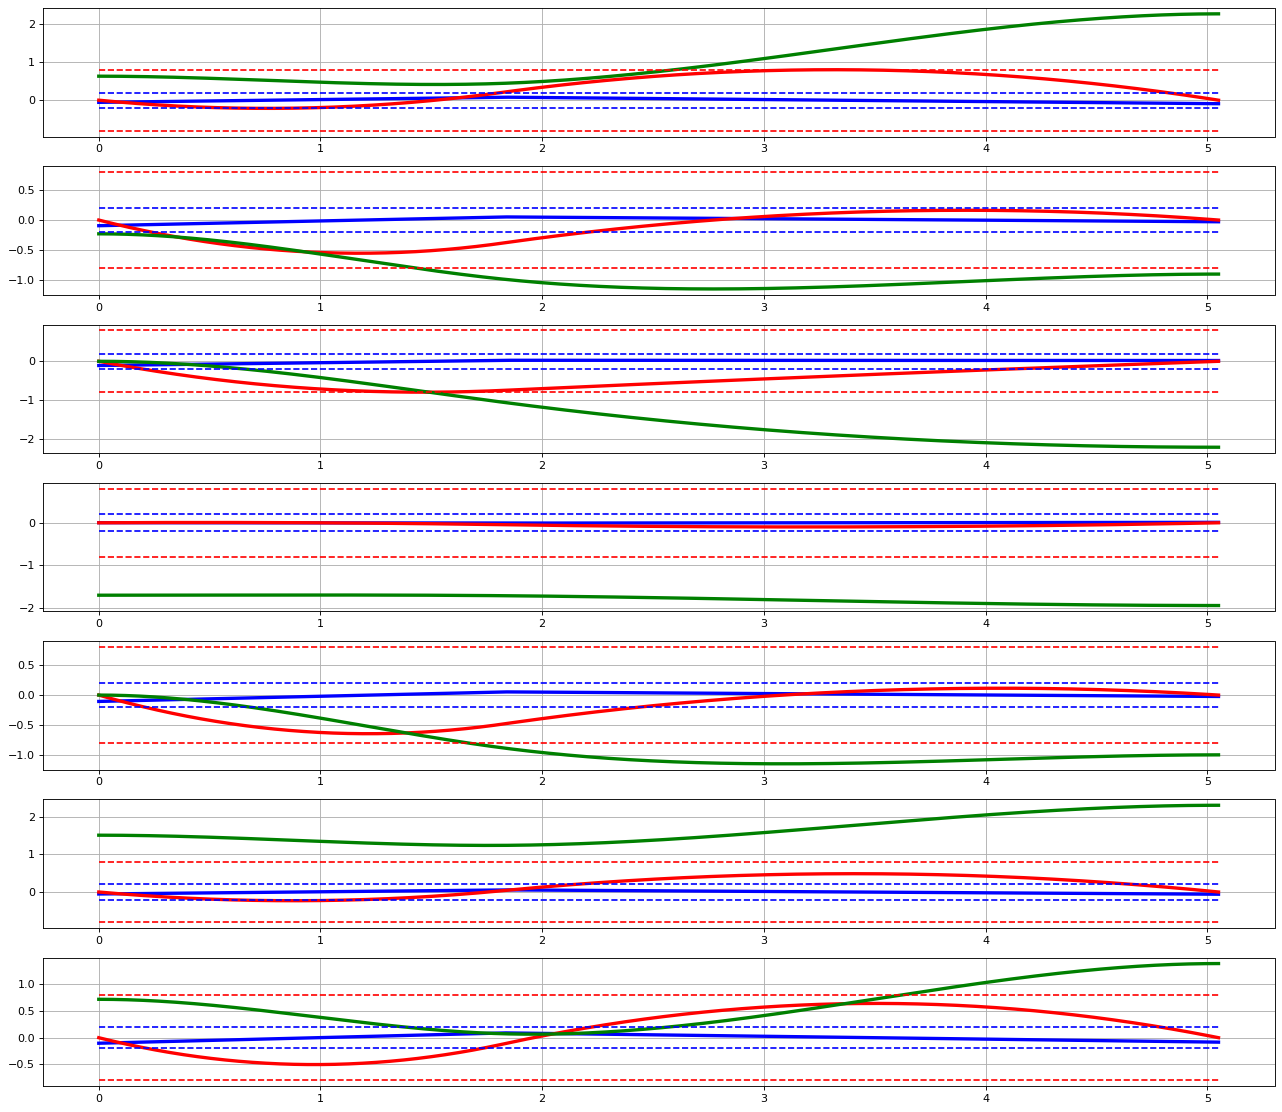

In [18]:
N = 500

q_s1, dq_s1, ddq_s1, t1 = getTrajectory(w_opt[:2*ndof], T_opt[0], int(T_opt[0]*N), q_0, dq_0)
q_s2, dq_s2, ddq_s2, t2 = getTrajectory(w_opt[2*ndof:], T_opt[1], int(T_opt[1]*N), q_s1[-ndof:], dq_s1[-ndof:])

ddq = np.concatenate((ddq_s1[:-ndof], ddq_s2))
dq = np.concatenate((dq_s1[:-ndof], dq_s2))
q = np.concatenate((q_s1[:-ndof], q_s2))

t = np.concatenate((t1[:-1], t2+t1[-1]))

fig, axs = plt.subplots(ndof, 1, figsize=(16, ndof*2), dpi= 80, facecolor='w', edgecolor='k')

for i in range(ndof):
    axs[i].plot(t, 0.1*ddq[i::ndof], 'b', lw=3)
    axs[i].plot(t, dq[i::ndof], 'r', lw=3)
    axs[i].plot(t, q[i::ndof], 'g', lw=3)
    axs[i].grid(True)

    axs[i].plot([0,np.sum(T_opt)],[dq_lim, dq_lim],'r--')
    axs[i].plot([0,np.sum(T_opt)],[-dq_lim, -dq_lim],'r--')

    axs[i].plot([0,np.sum(T_opt)],0.1*np.array([ddq_lim, ddq_lim]),'b--')
    axs[i].plot([0,np.sum(T_opt)],0.1*np.array([-ddq_lim, -ddq_lim]),'b--')

# axs[1].set_xlabel('t', fontsize = 24)

# axs[0].set_ylabel('vel & acc/10 (DoF 1)', fontsize = 24)
# axs[1].set_ylabel('vel & acc/10 (DoF 2)', fontsize = 24)

fig.tight_layout()
plt.show()

In [19]:
world_sim.GUI()
world_sim.set_time_step(dt_con)
world_sim.setup_scene()
robot = world_sim.load_panda(pos=[0,0,0], orn=[0,0,0])

/home/julius/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [20]:
q_home = q_0
#q_home = np.array([-0.6, -0.0, -0.3, -2.6, 0.0, 2.4, 0.7])
#q_home = np.array([0, 0, 0, -2.6, 0.0, 2.4, 0.7])

robot.default_q = q_home

robot.mimic_motor = False
robot.reset_q(max_iter=100)

In [22]:
N_sim = len(t)

dt_replay = 0.005
N_replay = int(np.sum(T_opt) / dt_replay)

log_q = q.reshape((int(len(q)/ndof),ndof))

robot.mimic_motor = False
robot.reset_q(max_iter=100)
robot.joints_free=True

world_sim.remove_all_objects()
p1 = world_sim.load_marker(pos=[0,0,0], orn=[0,0,0])
p2 = world_sim.load_marker(pos=[0,0,0], orn=[0,0,0])
ee = world_sim.load_marker(pos=[0,0,0], orn=[0,0,0])

p1.set_position_orientation(pos=x_1)
p2.set_position_orientation(pos=x_2)

for i in range(0, N_replay-1):
    n = int(i * N_sim / N_replay)
    # Read robot state
    q_ = log_q[n,:]
    robot.set_q(q_)
    
#     s = s0 + np.array([a * np.sin(i/N_replay * w*np.pi), a * np.cos(i/N_replay * w*np.pi)])
#     sphere.set_position_orientation(pos=np.array([s[0],s[1],0.05]))
    
    ee.set_position_orientation(pos=robot.x)
    
    time.sleep(dt_replay)

joints are free now
